In [1]:
# %tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [ ]:
# Testing Commit for git..
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa, librosa.display
import os
import tensorflow as tf
print(tf.__version__)
import re
import sklearn
import datetime
import pandas as apd
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
%load_ext tensorboard

2.17.0


In [4]:
tf.random.set_seed(999)
np.random.seed(999)

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# !ls 'drive/My Drive/audio-quality-cnn/dataset'

In [5]:
## librosa config
NUM_CLASSES=4
SAMPLE_RATE=44100
N_MFCC=40
WINDOW_LENGTH=1024 # Previously : 512
OVERLAP=round(0.25 * WINDOW_LENGTH)
BATCH_SIZE=16
LEARNING_RATE=8e-5
WINDOW = scipy.signal.windows.hamming(WINDOW_LENGTH, sym=False)

In [33]:
dataset_prefix_name = 'STFT_MAG'

# save the numpy data
X_test = np.load('__TEST__[New_Low+Vol]_WindLen_650__650.npy', allow_pickle=True).item()
X_train = np.load('__TRAIN__[New_Low_Vol]_WindLen_650__650.npy', allow_pickle=True).item()
print(X_test.keys())

dict_keys(['filenames', 'features', 'class_labels'])


In [34]:
def filter_data_by_labels(dataset, target_labels=(0, 3)):
    features = dataset['features']
    labels = dataset['class_labels']
    filenames = dataset['filenames']

    # Get indices where labels are either 0 or 1
    indices = [i for i, label in enumerate(labels) if label in target_labels]

    # Filter features, labels, and filenames
    filtered_features = [features[i] for i in indices]
    filtered_labels = [labels[i] for i in indices]
    filtered_filenames = [filenames[i] for i in indices]

    # Return new dataset
    return {
        'filenames': filtered_filenames,
        'features': filtered_features,
        'class_labels': filtered_labels
    }

# Create new datasets with only class labels 0 and 1
new_X_train = filter_data_by_labels(X_train)
new_X_test = filter_data_by_labels(X_test)

In [35]:
X_train['class_labels']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 0])

In [36]:
X_test['class_labels']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3])

In [37]:
type(X_train['features'])

numpy.ndarray

In [38]:
train_filenames = X_train['filenames']
# y_train_scores = X_train['sample_MOS']
y_train_classes = X_train['class_labels']
X_train_features = X_train['features']
input_height = X_train_features.shape[1]

print("Train data")
print("Features shape:", X_train_features.shape)
print("class_labels shape:", y_train_classes.shape)
# print("sample_MOS shape:", y_train_scores.shape)

Train data
Features shape: (120, 326, 1241, 1, 1)
class_labels shape: (120,)


In [39]:
test_filenames = X_test['filenames']
# y_test_scores = X_test['sample_MOS']
y_test_classes = X_test['class_labels']
X_test_features = X_test['features']

print("Test data")
print("Features shape:", X_test_features.shape)
print("class_labels shape:", y_test_classes.shape)
# print("sample_MOS shape:", y_test_scores.shape)

Test data
Features shape: (61, 326, 1241, 1, 1)
class_labels shape: (61,)


In [40]:
## normalization
def whitening(feature_vector):
  # print(feature_vector.shape)
  mean = np.expand_dims(np.mean(feature_vector))
  std = np.expand_dims(np.std(feature_vector))
  feature_vector = (feature_vector - mean) / std
  return feature_vector

In [41]:
assert np.intersect1d(train_filenames, test_filenames).shape == (0,), "It seems there is data leakage between train and test."

In [42]:
from tensorflow.keras.layers import Conv2D, Input, GlobalAveragePooling2D, LeakyReLU, Flatten, Dense, Reshape, MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation, Input, Dropout, SpatialDropout2D
from tensorflow.keras import Model, Sequential

In [43]:
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = inputs

    # Conv --> BN --> Activation --> MaxPool --> [Dropout 2D]
    x = Conv2D(filters=16, kernel_size=3, padding='same', input_shape=input_shape)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=24, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=32, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = SpatialDropout2D(0.15)(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = SpatialDropout2D(0.25)(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = SpatialDropout2D(0.25)(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = SpatialDropout2D(0.25)(x)
    
    # scores branch 
    # x_score = Conv2D(filters=32, kernel_size=3, padding='same')(x)
    # x_score = BatchNormalization()(x_score)
    # x_score = Activation('relu')(x_score)
    # x_score = MaxPooling2D(pool_size=2)(x_score)
    # x_score = SpatialDropout2D(0.25)(x_score)

    # x_score = Conv2D(filters=32, kernel_size=3, padding='same')(x_score)
    # x_score = BatchNormalization()(x_score)
    # x_score = Activation('relu')(x_score)
    # x_score = MaxPooling2D(pool_size=2)(x_score)
    # x_score = SpatialDropout2D(0.25)(x_score)
    # x_score = GlobalAveragePooling2D()(x_score)
    # x_score = Dense(1, name='output_mos')(x_score)

    # claas branch 
    x_class = Conv2D(filters=32, kernel_size=3, padding='same')(x)
    x_class = BatchNormalization()(x_class)
    x_class = Activation('relu')(x_class)
    x_class = MaxPooling2D(pool_size=2)(x_class)
    x_class = SpatialDropout2D(0.25)(x_class)

    x_class = Conv2D(filters=48, kernel_size=3, padding='same')(x_class)
    x_class = BatchNormalization()(x_class)
    x_class = Activation('relu')(x_class)
    x_class = MaxPooling2D(pool_size=2)(x_class)
    x_class = SpatialDropout2D(0.35)(x_class)
    x_class = GlobalAveragePooling2D()(x_class)
    x_class = Dense(NUM_CLASSES, activation='softmax', name='output_class')(x_class)
    
    model = Model(inputs=inputs, outputs=[x_class])
    return model

In [44]:
model = build_model((input_height, None, 1))

optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss={
                    'output_class': 'sparse_categorical_crossentropy'}, 
              loss_weights={
                    'output_class': 0.035137951618966407},
              metrics={
                  'output_class': tf.keras.metrics.SparseCategoricalAccuracy()
              },
              optimizer=optimizer)

# Display model architecture summary 
model.summary()


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 326, None, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 326, None, 16)       │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 326, None, 16)       │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 326, None, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 163, None, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 163, None, 24)       │           3,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 163, None, 24)       │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 163, None, 24)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 81, None, 24)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 81, None, 32)        │           6,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 81, None, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 81, None, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 40, None, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_6                  │ (None, 40, None, 32)        │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 40, None, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 40, None, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 40, None, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 20, None, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_7                  │ (None, 20, None, 64)        │              

 Total params: 303,372 (1.16 MB)

 Trainable params: 302,428 (1.15 MB)

 Non-trainable params: 944 (3.69 KB)

In [18]:
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [45]:
monitor_metric='val_loss'

early_stopping_callback = tf.keras.callbacks.EarlyStopping(mode='auto', monitor=monitor_metric, patience=100, restore_best_weights=True)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='epoch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='drive/My Drive/audio-quality-cnn/model.keras', 
                                                         monitor=monitor_metric, save_best_only=True)

In [46]:
def whitening(image,  y2):
    # normalization using the image mean and std tends to produce under-optimized models
    # mean = tf.math.reduce_mean(image)
    # std = tf.math.reduce_std(image)
    mean = tf.expand_dims(tf.math.reduce_mean(image, axis=1), axis=1)
    std = tf.expand_dims(tf.math.reduce_std(image, axis=1), axis=1)
    image = (image - mean) / std
    return image,  y2
    
def random_crop(image,  y2):
    h = image.shape[0]
    return tf.math.abs(tf.image.random_crop(image, size=(h,416,1))),  y2

def cutout(image,  y2, cutout_size=24):
    h, w = image.shape[:2]
    mask = tf.zeros((24,24))

    left = tf.random.uniform(shape=(), minval=0, maxval=w-cutout_size, dtype=tf.int32)
    right = w - (cutout_size + left)

    top = tf.random.uniform(shape=(), minval=0, maxval=h-cutout_size, dtype=tf.int32)
    bottom = h - (cutout_size + top)

    mask = tf.pad(mask, [[top, bottom], [left, right]], constant_values=1)
    image = image * tf.expand_dims(mask, 2)
    return image, label

def prepare_input_format(image,  y2):
  return image, {'output_class': y2}

In [47]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_features, y_train_classes))
# train_dataset = train_dataset.map(random_crop)
train_dataset = train_dataset.map(whitening)
train_dataset = train_dataset.map(prepare_input_format)
train_dataset = train_dataset.shuffle(buffer_size=1024)
train_dataset = train_dataset.repeat(1)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [48]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_features, y_test_classes))
test_dataset = test_dataset.map(whitening)
test_dataset = test_dataset.map(prepare_input_format)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(256)

In [49]:
steps_per_epoch = X_train_features.shape[0] // BATCH_SIZE
print("steps_per_epoch:",steps_per_epoch)

steps_per_epoch: 7


In [50]:
history = model.fit(X_train_features,
          { 'output_class': y_train_classes},
          validation_data=(X_test_features, 
                           { 'output_class': y_test_classes}),
          batch_size=BATCH_SIZE,
          epochs=100,
          callbacks=[early_stopping_callback, tensorboard_callback, checkpoint_callback]
        )

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.0574 - sparse_categorical_accuracy: 0.3519 - val_loss: 0.0425 - val_sparse_categorical_accuracy: 0.5082
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.0526 - sparse_categorical_accuracy: 0.3475 - val_loss: 0.0389 - val_sparse_categorical_accuracy: 0.5082
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.0432 - sparse_categorical_accuracy: 0.4948 - val_loss: 0.0370 - val_sparse_categorical_accuracy: 0.5246
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.0349 - sparse_categorical_accuracy: 0.6498 - val_loss: 0.0366 - val_sparse_categorical_accuracy: 0.5082
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.0325 - sparse_categorical_accuracy: 0.6040 - val_loss: 0.0377 - val_sparse_categorical_accuracy: 0.4918
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.0238 - sparse_categorical_accuracy: 0.7750 - val_loss: 0.0401 - val_sparse_categorical_accuracy: 0.4262
Epoch 7/100
8/8 ━━━━━━

In [51]:
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, mean_squared_error, mean_absolute_error
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [52]:
model.evaluate(test_dataset) # This is fpr 100 epochs

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2867 - sparse_categorical_accuracy: 0.3607


[0.2866984009742737, 0.3606557250022888]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


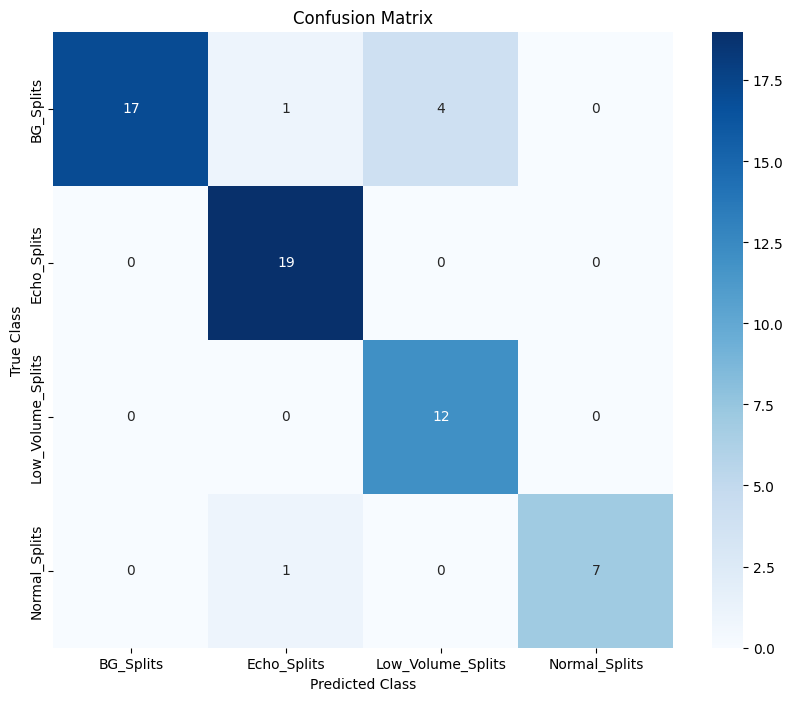

In [58]:
# 1. Predict class probabilities on the test set
import seaborn as sns
y_pred_probs = model.predict(X_test_features)

# 2. Convert probabilities to predicted class labels
# Assuming `y_test_classes` is sparse (integer-encoded), use `argmax`
y_pred_classes = np.argmax(y_pred_probs, axis=1)
class_names = ['BG_Splits', 'Echo_Splits', 'Low_Volume_Splits', 'Normal_Splits']

# 3. Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# 4. Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()
# For WD = 650 , Epoch = 100  , Additional Architecture

In [54]:
# Save the entire model
model.save("CNN_Model_V2_Window_Len_650.keras")

In [55]:
# NOISE_CLASS_MAP = ['NOISE', 'CHOP', 'COMPSPKR', 'ECHO', 'CLIP']

# model.load_weights('drive/My Drive/audio-quality-cnn/multiclass.h5')
out_probs = model.predict(X_test_features)
predictions = np.argmax(out_probs, axis=1)

print(predictions.shape)
# conf_matrix = confusion_matrix(predictions, y_test_classes)
# _ = plot_confusion_matrix(conf_matrix, classes=NOISE_CLASS_MAP)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
(61,)


In [ ]:
predictions

In [ ]:
from sklearn.metrics import classification_report

In [56]:
print("Balanced Accuracy:", balanced_accuracy_score(y_test_classes, predictions))
print("Accuracy:", accuracy_score(y_test_classes, predictions))
print("Precision:", precision_score(y_test_classes, predictions, average='weighted'))
print("Recall:", recall_score(y_test_classes, predictions, average='weighted'))

Balanced Accuracy: 0.9119318181818181
Accuracy: 0.9016393442622951
Precision: 0.9211553473848556
Recall: 0.9016393442622951


In [ ]:
class FeatureExtractor:
    def __init__(self, windowLength, overlap, sample_rate):
        self.ffT_length = windowLength
        self.window_length = windowLength
        self.overlap = overlap
        self.sample_rate = sample_rate
        self.window = scipy.signal.windows.hamming(self.window_length, sym=False)

    def get_stft_spectrogram(self, audio, spectrogram=False):
        S = librosa.stft(audio, n_fft=self.ffT_length, win_length=self.window_length, hop_length=self.overlap,
                            window=self.window, center=True)
        S = np.abs(S)
        if spectrogram:
            return np.square(S)
        else:
            return S

    def get_constant_q_spectrogram(self, audio, n_bins=84):
        # Compute the constant-Q transform of an audio signal.
        C = librosa.core.cqt(audio, sr=self.sample_rate, hop_length=self.overlap, fmin=None,
                                n_bins=n_bins, bins_per_octave=12, tuning=0.0,
                                filter_scale=1, norm=1, sparsity=0.01, window='hann', scale=True,
                                pad_mode='reflect',
                                res_type=None)
        return np.abs(C)

    def get_mfcc_features(self, audio, n_mfcc=40):
        S = self.get_mel_spectrogram(audio)
        return librosa.feature.mfcc(S=librosa.power_to_db(S), sr=self.sample_rate, n_mfcc=n_mfcc)

    def get_mel_spectrogram(self, audio):
        D = self.get_stft_spectrogram(audio, spectrogram=True)
        S = librosa.feature.melspectrogram(S=D, sr=self.sample_rate, power=2.0, pad_mode='reflect',
                                              n_fft=self.ffT_length, hop_length=self.overlap, center=True)
        return S

In [ ]:
extractor = FeatureExtractor(WINDOW_LENGTH, OVERLAP, SAMPLE_RATE)

In [ ]:
def get_feature_extractor_func(feature_type):
    print("Feature type:", feature_type)
    feature_map = {'STFT_SPEC': lambda audio: extractor.get_stft_spectrogram(audio, spectrogram=True),
                   'STFT_MAG' : lambda audio: extractor.get_stft_spectrogram(audio, spectrogram=False),
                   'MFCC': lambda audio: extractor.get_mfcc_features(audio),
                   'MEL_SPEC': lambda audio: extractor.get_mel_spectrogram(audio),
                   'CQT': lambda audio: extractor.get_constant_q_spectrogram(audio)}
    return feature_map.get(feature_type)

In [ ]:
extractor = FeatureExtractor(WINDOW_LENGTH, OVERLAP, SAMPLE_RATE)
get_feature_vector = get_feature_extractor_func('STFT')

In [ ]:
max_feature_len = []
def extract_features(audio, sr, max_pad_len):
   
    try:
        features = get_feature_vector(audio)
        pad_width = max_pad_len - features.shape[1]
        max_feature_len.append(features.shape[1])
        
        if pad_width < 0:
            print("Cropping original features depth of:", features.shape[1], 'to:', max_pad_len)
            features = features[:,:max_pad_len]
        else:
            features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='wrap')
            
    except Exception as e:
        print("Error encountered.", e)
        return None 
     
    return features

In [ ]:
audio, sr = librosa.load("D:/Google's_Audio_Quality/audio_files/BG_Splits/part_1_BG_File_Split1.wav", sr=44100)
f_map = get_feature_extractor_func(audio)

In [ ]:
def _remove_silent_frames(audio):
    trimed_audio = []
    indices = librosa.effects.split(audio, top_db=60)

    for index in indices:
        trimed_audio.extend(audio[index[0]: index[1]])
    return np.array(trimed_audio)

In [ ]:
audio =  _remove_silent_frames(audio)
feature_vector = extract_features(audio, sr, 1241)

In [ ]:
type(feature_vector)